# Домашнее задание 3

[x] [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

[x] [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

[ ] [3 балла] Реализуйте приведение изображения листка к "виду сверху"

[ ] [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

[ ] [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

[ ] [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [1]:
!git clone -b develop https://github.com/AZhed/cvr_course.git

Cloning into 'cvr_course'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 207 (delta 2), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (207/207), 53.56 MiB | 35.07 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [2]:
cd cvr_course/notebooks

/content/cvr_course/notebooks


image 0 distance:  86.98571825076148
image 1 distance:  94.46607561991895
image 2 distance:  95.15204916054759
image 3 distance:  91.01858143265916
image 4 distance:  90.73458176535522
image 5 distance:  91.52729634801733
image 6 distance:  58.213898179172
image 7 distance:  94.81533612993083
image 8 distance:  77.07543760345204
image 9 distance:  64.91511152926601


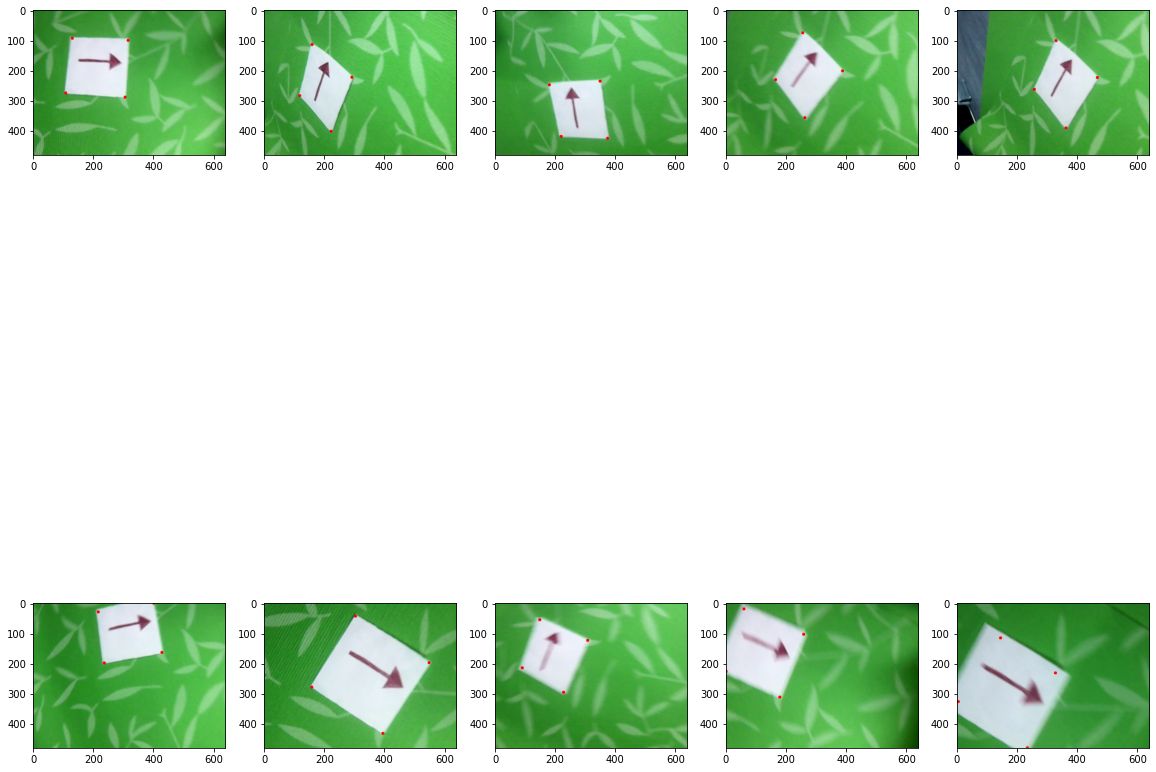

In [147]:
import numpy as np
import cv2
import time
import os
import math
import sys
import glob
from matplotlib import pyplot as plt


imgs = glob.glob ("../data/imgs/arrow/*.png")



def find_contour(img):

    low = 200
    high = 255
    low_th  = (low, low, low)
    high_th = (high, high, high)

    mask = cv2.inRange (img, low_th, high_th)   
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 30))
    threshed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, rect_kernel)

    contours, hierarchy = cv2.findContours (threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    good_contours = []
    for contrs in contours:
        length = cv2.arcLength (contrs, True)
        if  length > 200:
            good_contours.append(contrs)

    cnt = good_contours[0]
    approx_h = cv2.convexHull (cnt)

    epsilon = 0.05 * cv2.arcLength (approx_h, True)
    approx = cv2.approxPolyDP (approx_h, epsilon, True)

    return approx

def find_distance(approx):
    length = cv2.arcLength (approx, True)
    distance = 180.0 * 364 / length
    
    return distance


fig, ax = plt.subplots(2, 5, figsize=(20, 20))
for frame in imgs:
    img = cv2.imread(frame)

    
    
    approx = find_contour(img)
        
    distance = find_distance(approx)
    
            
    i = imgs.index(frame)
    print("image" ,i , "distance: ",  distance)

    cv2.drawContours(img, approx, -1, (255, 0, 0), 10)
    
    if i < 5:
        ax[0, i].imshow(img)
    else:
        ax[1, i-5].imshow(img)
        
plt.show()


In [173]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def four_point_transform(image, pts):
    
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    print(M)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped




In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 20))
for frame in imgs:

    img = cv2.imread(frame)

    approx = find_contour(img)
    # print(np.asarray(approx) [:, 0, :])
    warped = four_point_transform (img, np.asarray (approx) [:, 0, :])

    i = imgs.index(frame)
    if i < 5:
        ax[0, i].imshow(warped)
    else:
        ax[1, i-5].imshow(warped)
        
plt.show()

[[ 1.01874696e+00 -2.32345798e-01 -1.25985041e+02]
 [ 6.58843352e-02  9.22380692e-01 -2.39687211e+02]
 [ 5.64413419e-04 -6.59034560e-04  1.00000000e+00]]


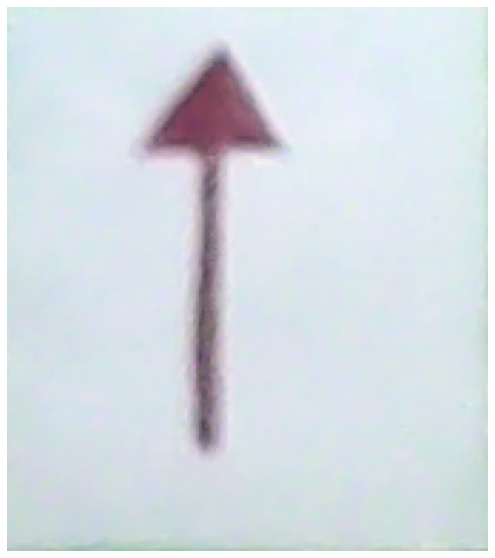

In [177]:
imgs = glob.glob ("../data/imgs/arrow/*.png")
plt.rcParams["figure.figsize"] = (10,10)

img = cv2.imread(imgs[2])

approx = find_contour(img)
# print(np.asarray(approx) [:, 0, :])
warped = four_point_transform (img, np.asarray (approx) [:, 0, :])

plt.imshow(warped)
plt.axis('off')
plt.show()

In [7]:
len(contours)

1